# Weeaboo Subsite Overview

## Preliminary Preparations

In [1]:
import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

import json
import yaml
import ast

import requests
import IPython.display as Disp

from re import findall, match
import itertools

from datetime import datetime
from datetime import tzinfo

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [2]:
PATH = "/home/aleksey/PycharmProjects/DTF_database_and_scrapper_config/"

In [3]:
weeaboo_origin = pd.read_csv(PATH + 'data_weeaboo_01_03.csv', index_col=0)
weeaboo_origin.reset_index(inplace=True)
weeaboo_origin.drop(columns=['index'], inplace=True)
weeaboo_origin.head()

,id,url,author,badges,commentsCount,commentsSeenCount,favoritesCount,cover,date,dateRFC,...,is_show_thanks,is_still_updating,is_filled_by_editors,isEditorial,audioUrl,hotness,commentEditor,summarize,repost,stackedRepostsAuthors
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...","[{'type': 'top', 'text': 'Виабу', 'background'...",46,NaN,13,"{'additionalData': {'size': 205672, 'type': 'p...",1613734784,"Fri, 19 Feb 2021 14:39:44 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Обсуждения аниме, манги и ранобе. Маленький кл...",NaN,NaN
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...","[{'type': 'top', 'text': 'Виабу', 'background'...",0,NaN,0,"{'additionalData': {'size': 718474, 'type': 'g...",1614588748,"Mon, 01 Mar 2021 11:52:28 +0300",...,False,False,False,False,NaN,0,{'enabled': True},NaN,NaN,NaN
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...","[{'type': 'top', 'text': 'Виабу', 'background'...",0,NaN,1,"{'additionalData': {'size': 69598, 'type': 'jp...",1614588426,"Mon, 01 Mar 2021 11:47:06 +0300",...,False,False,False,False,NaN,0,{'enabled': True},#1memetime #weeaboo #shitpost #anime #meme,NaN,NaN
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...","[{'type': 'top', 'text': 'Виабу', 'background'...",1,NaN,0,"{'additionalData': {'size': 403323, 'type': 'j...",1614587634,"Mon, 01 Mar 2021 11:33:54 +0300",...,False,False,False,False,NaN,0,{'enabled': True},NaN,NaN,NaN
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...","[{'type': 'top', 'text': 'Revendi', 'backgroun...",2,NaN,17,"{'additionalData': {'size': 785074, 'type': 'j...",1614550081,"Mon, 01 Mar 2021 01:08:01 +0300",...,False,False,False,False,NaN,0,{'enabled': True},Внутри вкусно #виабу #чулки #horny,"{'author': {'id': 261696, 'url': 'https://dtf....",[]


In [4]:
weeaboo_origin.tail(3)

,id,url,author,badges,commentsCount,commentsSeenCount,favoritesCount,cover,date,dateRFC,...,is_show_thanks,is_still_updating,is_filled_by_editors,isEditorial,audioUrl,hotness,commentEditor,summarize,repost,stackedRepostsAuthors
6174,170958,https://dtf.ru/s/weaboo/170958,"{'id': 197370, 'url': 'https://dtf.ru/u/197370...","[{'type': 'top', 'text': 'Виабу', 'background'...",8,NaN,1,"{'additionalData': {'size': 2761663, 'type': '...",1594749437,"Tue, 14 Jul 2020 20:57:17 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Говоров красава, спасибо за анимемы на дтф",NaN,NaN
6175,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...","[{'type': 'top', 'text': 'Виабу', 'background'...",6,NaN,1,"{'additionalData': {'size': 5588717, 'type': '...",1594748952,"Tue, 14 Jul 2020 20:49:12 +0300",...,False,False,False,False,NaN,0,{'enabled': True},Иначе я в Драме запосщу как они до меня домога...,NaN,NaN
6176,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...","[{'type': 'top', 'text': 'Виабу', 'background'...",40,NaN,4,"{'additionalData': {'size': 287640, 'type': 'j...",1594746603,"Tue, 14 Jul 2020 20:10:03 +0300",...,False,False,False,False,NaN,0,{'enabled': True},"Еще один мертвый подсайт, но зато с аниме Вмес...",NaN,NaN


In [5]:
weeaboo_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6177 non-null   int64  
 1   url                     6177 non-null   object 
 2   author                  6177 non-null   object 
 3   badges                  6177 non-null   object 
 4   commentsCount           6177 non-null   int64  
 5   commentsSeenCount       0 non-null      float64
 6   favoritesCount          6177 non-null   int64  
 7   cover                   6018 non-null   object 
 8   date                    6177 non-null   int64  
 9   dateRFC                 6177 non-null   object 
 10  date_favorite           0 non-null      float64
 11  last_modification_date  6177 non-null   int64  
 12  hitsCount               6177 non-null   int64  
 13  intro                   3464 non-null   object 
 14  introInFeed             0 non-null      

**Потенциально полезно:**
- id -- ИД статьи в базе, инкрементный идентификатор
- url -- ссылка на статью
- author -- автор: словарь с данными, нужна обработка
- commentsCount -- кол-во комментов
- favoritesCount -- кол-во добавлений в закладки
- cover -- это КПДВ (нужно ли?)
- date -- unix timestamp
- dateRFC -- человекочитаемое время, UTC+3
- hitsCount -- просмотры
- isRepost -- бинарный маркер репоста
- likes -- лайки: словарь, нужна обработка
- subsite -- подсайт, в котором опубликован оригинал статьи
- title -- заголовок
- type -- тип статьи 
- entryContent -- содержимое поста
- repost -- подсайт из которого сделан репост: словарь, нужна обработка
- stackedRepostsAuthors -- репостнувшие пользователи/подсайты - список
- blocks -- содержимое поста поблочно. 
- summarize -- последний абзац/резюмирующий абзац - видимо, некая фича редактора

## Data Preprocessing

In [6]:
date_parser = lambda x: datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

In [7]:
df = pd.read_csv(PATH + "data_weeaboo_01_03.csv", parse_dates=['date'], date_parser=date_parser, 
                 index_col=None, # None / 0 / ['date']
                 usecols=['id', 'url', 'author', 'commentsCount', 'favoritesCount', 'date', 
                          'hitsCount', 'isRepost', 'likes', 'subsite', 'title', 'type', 
                          'repost', 'stackedRepostsAuthors', 'blocks'])
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,"{'is_liked': 0, 'count': 47, 'summ': 47, 'is_h...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",Официальный дискорд Виабу,1,"[{'type': 'text', 'data': {'text': 'Сервер сно...",NaN,NaN
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,"{'is_liked': 0, 'count': 2, 'summ': 2, 'is_hid...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,"{'is_liked': 0, 'count': 6, 'summ': 6, 'is_hid...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,"{'is_liked': 0, 'count': 6, 'summ': 6, 'is_hid...","{'id': 261696, 'url': 'https://dtf.ru/s/weaboo...",NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,"{'is_liked': 0, 'count': 31, 'summ': 31, 'is_h...","{'id': 130359, 'url': 'https://dtf.ru/u/130359...",Horny чулочки,1,"[{'type': 'text', 'data': {'text': 'Внутри вку...","{'author': {'id': 261696, 'url': 'https://dtf....",[]


In [8]:
df.shape

(6177, 15)

Нужно:
- id
- url
- author -- автор: словарь с данными, нужна обработка
- commentsCount -- кол-во комментов
- favoritesCount -- кол-во добавлений в закладки
- date -- unix timestamp
- dateRFC -- человекочитаемое время, UTC+3
- hitsCount -- просмотры
- isRepost -- бинарный маркер репоста
- likes -- лайки, словарь, нужна обработка
- subsite -- подсайт, в котором опубликован оригинал статьи
- title -- заголовок
- type -- тип статьи 
- repost -- подсайт из которого сделан репост, словарь, нужна обработка
- stackedRepostsAuthors -- репостнувшие пользователи/подсайты - список
- blocks -- содержимое поста поблочно. 

Извлечём виды контента, содержащиеся в посте.

In [9]:
def get_medias(media):
    """
        Extracting mediacontent types from pd.Series
    """
    medias = []
    for x in media:
        medias.append(x['type'])
    return(set(medias))    

Преобразуем лайки, автора и подсайт в удобочитаемый формат.

In [10]:
df['likes'] = df['likes'].apply(lambda x: ast.literal_eval(x))
df['likes'] = df['likes'].apply(lambda x: x.get('summ'))

medias = df.loc[:, 'blocks']
medias_resume_list = medias.apply(lambda x: ast.literal_eval(x))
df['media_content_types'] = medias_resume_list.apply(lambda el: get_medias(el))


df['author'] = df['author'].apply(lambda x: ast.literal_eval(x))
df['author_name'] = df['author'].apply(lambda x: x.get('name'))
df['author_type'] = df['author'].apply(lambda x: x.get('type'))
df['author_avatar_url'] = df['author'].apply(lambda x: x.get('avatar_url'))

df['subsite'] = df['subsite'].apply(lambda x: ast.literal_eval(x))
df['subsite'] = df['subsite'].apply(lambda x: x.get('name'))

In [11]:
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,Официальный дискорд Виабу,1,"[{'type': 'text', 'data': {'text': 'Сервер сно...",NaN,NaN,"{media, header, video, link, text, quote, deli...",Kurisu Makise,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Koda,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN,"{media, text}",Suzume-sama said OKawaii Koto,1,https://leonardo.osnova.io/1315d174-7208-5a30-...
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,Horny чулочки,1,"[{'type': 'text', 'data': {'text': 'Внутри вку...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Revendi,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...


---
### Проведём тесты на небольшом кусочке датасета
---

In [12]:
df_subs = df.loc[0:5, :]
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,Официальный дискорд Виабу,1,"[{'type': 'text', 'data': {'text': 'Сервер сно...",NaN,NaN,"{media, header, video, link, text, quote, deli...",Kurisu Makise,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Koda,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN,"{media, text}",Suzume-sama said OKawaii Koto,1,https://leonardo.osnova.io/1315d174-7208-5a30-...
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,Horny чулочки,1,"[{'type': 'text', 'data': {'text': 'Внутри вку...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Revendi,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...
5,657831,https://dtf.ru/s/weaboo/657831,"{'id': 334712, 'url': 'https://dtf.ru/u/334712...",0,1,2021-03-01 11:22:34,12,False,9,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Савва Лаков,1,https://leonardo.osnova.io/02293c89-0cd2-5168-...


In [13]:
df_subs['media_content_types']

0    {media, header, video, link, text, quote, deli...
1                                              {media}
2                                        {media, text}
3                                              {media}
4                                        {media, text}
5                                              {media}
Name: media_content_types, dtype: object

Создаём множество с самыми распространёнными типами контента в статьях. Остальное будем отлавливать специально.

In [14]:
etalon_set = {"media", "delimiter", "link", "header", "text", "video", "list", "telegram", "quote"}

In [15]:
df_subs.loc[:, 'exotic_media_type'] = df_subs.apply(lambda row: row.media_content_types - etalon_set, axis=1)
df_subs.loc[:, 'exotic_media_type'] = df_subs['exotic_media_type'].apply(lambda row: row if len(row) != 0 else 0)

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


https://stackoverflow.com/questions/58528989/pandas-get-unique-values-from-column-of-lists

https://datascience.stackexchange.com/questions/17769/how-to-fill-missing-value-based-on-other-columns-in-pandas-dataframe

https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/


In [16]:
df_subs['exotic_media_type'].explode().unique() 

array(['quiz', 0], dtype=object)

In [17]:
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,title,type,blocks,repost,stackedRepostsAuthors,media_content_types,author_name,author_type,author_avatar_url,exotic_media_type
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,Официальный дискорд Виабу,1,"[{'type': 'text', 'data': {'text': 'Сервер сно...",NaN,NaN,"{media, header, video, link, text, quote, deli...",Kurisu Makise,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...,{quiz}
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Koda,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...,0
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,_some:Meme,1,"[{'type': 'text', 'data': {'text': '[\\#1memet...",NaN,NaN,"{media, text}",Suzume-sama said OKawaii Koto,1,https://leonardo.osnova.io/1315d174-7208-5a30-...,0
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,Horny чулочки,1,"[{'type': 'text', 'data': {'text': 'Внутри вку...","{'author': {'id': 261696, 'url': 'https://dtf....",[],"{media, text}",Revendi,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...,0
5,657831,https://dtf.ru/s/weaboo/657831,"{'id': 334712, 'url': 'https://dtf.ru/u/334712...",0,1,2021-03-01 11:22:34,12,False,9,Виабу,NaN,1,"[{'type': 'media', 'data': {'items': [{'title'...",NaN,NaN,{media},Савва Лаков,1,https://leonardo.osnova.io/02293c89-0cd2-5168-...,0


Произведём расчёт количества символов, слов, хэш-тэгов, а также медиаконтента, содержащегося в статьях.

Ссылки на твиттер, телеграм и прочие источники учитываются как один тип.

Также виджет инстаграма учитывается как одно изображение, вне зависимости от количества изображений в галерее. Это вызвано тем, что API Очобы не отдаёт информацию о типе содержимого виджета.

https://stackoverflow.com/questions/48632356/python-extract-hashtags-out-of-a-text-file
    
https://stackoverflow.com/questions/2527892/parsing-a-tweet-to-extract-hashtags-into-an-array


Нужно попробовать вот этот паттерн [#][^\s#]+

In [18]:
def stats_counter(df: pd.DataFrame):
    
    # Гифки считаются изображениями-картинками
    
    symbols_by_block = []
    words_by_block = []
    
    image_counter = 0
    video_counter = 0
    audio_counter = 0
    
    links_counter = 0
    
    hashtags = []
      
    content_in_str = df['blocks']
    resume_list = ast.literal_eval(content_in_str) 
    
    for element in resume_list:
        if element['type'] in ['text', 'quote', 'header', 'incut', 'warning']:
            symbols_by_block.append(len(element['data']['text']))
            words_by_block.append(len(element['data']['text'].split()))
            hashtags.append(findall(r'#.*?(?=\s|$)', element['data']['text']))
            
        if element['type'] == 'number': 
            symbols_by_block.append(len(element['data']['title']))
            words_by_block.append(len(element['data']['title'].split()))

        if element['type'] == 'list': 
            for elem in element['data']['items']:
                symbols_by_block.append(len(elem))
                words_by_block.append(len(elem.split()))
                hashtags.append(findall(r'[#][^\s#]+', elem))

        if element['type'] == 'video':
            video_counter += 1

        if element['type'] == 'media': 
            for elem in element['data']['items']:
                image_counter += 1
                symbols_by_block.append(len(elem['title']))
                words_by_block.append(len(elem['title'].split())) 
                
        if element['type'] == 'instagram': 
            image_counter += 1
            
        if element['type'] in ['audio', 'spotify']:
            audio_counter += 1

        if element['type'] in ['tweet', 'link', 'telegram', 'person']: 
            links_counter += 1
    
    hashtags = [x for x in hashtags if x != []]
    hashtags = list(itertools.chain(*hashtags))    
    
    return(sum(symbols_by_block), sum(words_by_block), image_counter, video_counter, links_counter, audio_counter, hashtags)

In [19]:
df_subs.apply(lambda row: stats_counter(row), axis=1)

0    (1938, 289, 2, 5, 1, 0, [#weaboo, #discord, #а...
1                               (0, 0, 1, 0, 0, 0, [])
2    (106, 5, 1, 0, 0, 0, [#1memetime](https://dtf....
3                               (0, 0, 1, 0, 0, 0, [])
4        (34, 5, 3, 0, 0, 0, [#виабу, #чулки, #horny])
5                               (0, 0, 1, 0, 0, 0, [])
dtype: object

https://stackoverflow.com/questions/23586510/return-multiple-columns-from-pandas-apply

https://stackoverflow.com/questions/47969756/pandas-apply-function-that-returns-two-new-columns

https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns

In [20]:
df_subs[['symbols', 'words', 'images', 'videos', 'links', 'audio', 'hashtags']] = \
df_subs.apply(lambda row: stats_counter(row), axis=1, result_type='expand')

/home/aleksey/PycharmProjects/Machine_Learning_test_area/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
df_subs.loc[2, :]

id                                                                  657858
url                               https://dtf.ru/s/weaboo/657858-some-meme
author                   {'id': 124435, 'url': 'https://dtf.ru/u/124435...
commentsCount                                                            0
favoritesCount                                                           1
date                                                   2021-03-01 11:47:06
hitsCount                                                               13
isRepost                                                             False
likes                                                                    6
subsite                                                              Виабу
title                                                           _some:Meme
type                                                                     1
blocks                   [{'type': 'text', 'data': {'text': '[\\#1memet...
repost                   

In [22]:
df_subs

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_type,author_avatar_url,exotic_media_type,symbols,words,images,videos,links,audio,hashtags
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,...,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...,{quiz},1938,289,2,5,1,0,"[#weaboo, #discord, #аниме]"
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,...,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...,0,0,0,1,0,0,0,[]
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,...,1,https://leonardo.osnova.io/1315d174-7208-5a30-...,0,106,5,1,0,0,0,"[#1memetime](https://dtf.ru/tag/1memetime), #w..."
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,...,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,0,1,0,0,0,[]
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,...,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...,0,34,5,3,0,0,0,"[#виабу, #чулки, #horny]"
5,657831,https://dtf.ru/s/weaboo/657831,"{'id': 334712, 'url': 'https://dtf.ru/u/334712...",0,1,2021-03-01 11:22:34,12,False,9,Виабу,...,1,https://leonardo.osnova.io/02293c89-0cd2-5168-...,0,0,0,1,0,0,0,[]


---
### Возвращаемся к исходному датасету и применяем разработанные функции
---

In [23]:
df.apply(lambda row: stats_counter(row), axis=1)

0       (1938, 289, 2, 5, 1, 0, [#weaboo, #discord, #а...
1                                  (0, 0, 1, 0, 0, 0, [])
2       (106, 5, 1, 0, 0, 0, [#1memetime](https://dtf....
3                                  (0, 0, 1, 0, 0, 0, [])
4           (34, 5, 3, 0, 0, 0, [#виабу, #чулки, #horny])
                              ...                        
6172                               (0, 0, 1, 0, 0, 0, [])
6173                               (0, 0, 0, 1, 0, 0, [])
6174                              (42, 7, 1, 0, 0, 0, [])
6175                            (181, 26, 1, 0, 0, 0, [])
6176                            (118, 22, 1, 0, 0, 0, [])
Length: 6177, dtype: object

In [24]:
df[['symbols', 'words', 'images', 'videos', 'links', 'audio', 'hashtags']] = \
df.apply(lambda row: stats_counter(row), axis=1, result_type='expand')

In [25]:
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_name,author_type,author_avatar_url,symbols,words,images,videos,links,audio,hashtags
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,...,Kurisu Makise,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...,1938,289,2,5,1,0,"[#weaboo, #discord, #аниме]"
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,...,Koda,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...,0,0,1,0,0,0,[]
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,...,Suzume-sama said OKawaii Koto,1,https://leonardo.osnova.io/1315d174-7208-5a30-...,106,5,1,0,0,0,"[#1memetime](https://dtf.ru/tag/1memetime), #w..."
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,...,Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,1,0,0,0,[]
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,...,Revendi,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...,34,5,3,0,0,0,"[#виабу, #чулки, #horny]"


In [26]:
df.tail()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_name,author_type,author_avatar_url,symbols,words,images,videos,links,audio,hashtags
6172,171001,https://dtf.ru/s/weaboo/171001-satdog,"{'id': 127404, 'url': 'https://dtf.ru/u/127404...",1,1,2020-07-14 21:43:51,130,False,20,Виабу,...,Хасаги,1,https://leonardo.osnova.io/d1119c29-41a3-5997-...,0,0,1,0,0,0,[]
6173,170996,https://dtf.ru/s/weaboo/170996-milota,"{'id': 162369, 'url': 'https://dtf.ru/u/162369...",6,1,2020-07-14 21:34:11,106,False,18,Виабу,...,Asuka Soryu,1,https://leonardo.osnova.io/64144586-685c-5ee8-...,0,0,0,1,0,0,[]
6174,170958,https://dtf.ru/s/weaboo/170958,"{'id': 197370, 'url': 'https://dtf.ru/u/197370...",8,1,2020-07-14 20:57:17,116,False,19,Виабу,...,Le mort joyeux,1,https://leonardo.osnova.io/dc4f5913-3646-5404-...,42,7,1,0,0,0,[]
6175,170948,https://dtf.ru/s/weaboo/170948,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",6,1,2020-07-14 20:49:12,159,False,24,Виабу,...,Ayan Myrzagali,1,https://leonardo.osnova.io/c6fbeb6b-56c0-586d-...,181,26,1,0,0,0,[]
6176,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",40,4,2020-07-14 20:10:03,1358,False,62,Виабу,...,Лолег,1,https://leonardo.osnova.io/b6f745b6-3963-56d5-...,118,22,1,0,0,0,[]


In [27]:
etalon_set = {"media", "delimiter", "link", "header", "text", "video", "list", "telegram", "quote", 
              "tweet", "audio", "incut", "number", "instagram", "quiz", "warning", "spotify", "person"}

In [28]:
df.loc[:, 'exotic_media_type'] = df.apply(lambda row: row.media_content_types - etalon_set, axis=1)
df.loc[:, 'exotic_media_type'] = df['exotic_media_type'].apply(lambda row: row if len(row) != 0 else 0)

In [29]:
df['exotic_media_type'].explode().unique() 

array([0])

In [30]:
df[df['exotic_media_type'] != 0]

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_type,author_avatar_url,symbols,words,images,videos,links,audio,hashtags,exotic_media_type


In [31]:
df.drop(columns=['exotic_media_type'], inplace=True)

### Спустя 5 итераций наконец-то учтён контент всех типов. 
### Актуально на 14.03.2021. 

При выгрузке нового датасета стоит проверять появление новых видов контента.

# Exploratory Data Analysis

Разведочный анализ данных, визуализации, статистические исследования

Что можно сделать или проверить?

- Построить диаграммы рассеивания для параметров: лайки, кол-во медиаконтента, просмотры, комментарии

- Посмотреть корреляции между величинами

- Посчитать базовые описательные статистики: количество, средние 

- Кто написал максимальное количество статей?

- У кого самые популярные статьи? Критерии оценки: кол-во комментариев, просмотров, лайков.

- Посмотреть на описательные статистики по дням недели или по неделям

- Построить распределение длины постов: Кол-во постов в % от длины символов

In [32]:
df.head()

,id,url,author,commentsCount,favoritesCount,date,hitsCount,isRepost,likes,subsite,...,author_name,author_type,author_avatar_url,symbols,words,images,videos,links,audio,hashtags
0,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,2021-02-19 14:39:44,754,False,47,Виабу,...,Kurisu Makise,1,https://leonardo.osnova.io/20c519c3-d035-5e1b-...,1938,289,2,5,1,0,"[#weaboo, #discord, #аниме]"
1,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,2021-03-01 11:52:28,5,False,2,Виабу,...,Koda,1,https://leonardo.osnova.io/c29d8c44-0073-48cc-...,0,0,1,0,0,0,[]
2,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,2021-03-01 11:47:06,13,False,6,Виабу,...,Suzume-sama said OKawaii Koto,1,https://leonardo.osnova.io/1315d174-7208-5a30-...,106,5,1,0,0,0,"[#1memetime](https://dtf.ru/tag/1memetime), #w..."
3,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,2021-03-01 11:33:54,38,False,6,Виабу,...,Diego Paw,1,https://leonardo.osnova.io/7df667af-003c-502d-...,0,0,1,0,0,0,[]
4,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,2021-03-01 01:08:01,243,True,31,Revendi,...,Revendi,1,https://leonardo.osnova.io/cb64dbbb-dbba-eba3-...,34,5,3,0,0,0,"[#виабу, #чулки, #horny]"


### Хэштеги

https://stackoverflow.com/questions/37125174/accessing-every-1st-element-of-pandas-dataframe-column-containing-lists

In [33]:
pd.Series([x for item in df.hashtags for x in item])

0                                         #weaboo
1                                        #discord
2                                          #аниме
3       #1memetime](https://dtf.ru/tag/1memetime)
4           #weeaboo](https://dtf.ru/tag/weeaboo)
                          ...                    
7389                                   #Loveiswar
7390                                  #Kaguyasama
7391                                   #Loveiswar
7392                                       #anime
7393                                       #аниме
Length: 7394, dtype: object

In [34]:
df.hashtags = df.hashtags.apply(lambda x: [str(i).split(']', 1)[0] for i in x])
df.hashtags

0                            [#weaboo, #discord, #аниме]
1                                                     []
2       [#1memetime, #weeaboo, #shitpost, #anime, #meme]
3                                                     []
4                               [#виабу, #чулки, #horny]
                              ...                       
6172                                                  []
6173                                                  []
6174                                                  []
6175                                                  []
6176                                                  []
Name: hashtags, Length: 6177, dtype: object

In [35]:
hshtgs = pd.Series([x for item in df.hashtags for x in item])
# hshtgs.value_counts().head(50)

### Дни недели

In [36]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [37]:
df["hour"] = df.index.hour
df["weekday"] = df.index.day_name() #.weekday
df['is_weekend'] = df.weekday.isin(['Saturday',  'Sunday'])*1

In [38]:
df.head()

,id,url,author,commentsCount,favoritesCount,hitsCount,isRepost,likes,subsite,title,...,symbols,words,images,videos,links,audio,hashtags,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2021-02-19 14:39:44,647719,https://dtf.ru/s/weaboo/647719-oficialnyy-disk...,"{'id': 130392, 'url': 'https://dtf.ru/u/130392...",46,13,754,False,47,Виабу,Официальный дискорд Виабу,...,1938,289,2,5,1,0,"[#weaboo, #discord, #аниме]",14,Friday,0
2021-03-01 11:52:28,657866,https://dtf.ru/s/weaboo/657866,"{'id': 154947, 'url': 'https://dtf.ru/u/154947...",0,0,5,False,2,Виабу,NaN,...,0,0,1,0,0,0,[],11,Monday,0
2021-03-01 11:47:06,657858,https://dtf.ru/s/weaboo/657858-some-meme,"{'id': 124435, 'url': 'https://dtf.ru/u/124435...",0,1,13,False,6,Виабу,_some:Meme,...,106,5,1,0,0,0,"[#1memetime, #weeaboo, #shitpost, #anime, #meme]",11,Monday,0
2021-03-01 11:33:54,657849,https://dtf.ru/s/weaboo/657849,"{'id': 120739, 'url': 'https://dtf.ru/u/120739...",1,0,38,False,6,Виабу,NaN,...,0,0,1,0,0,0,[],11,Monday,0
2021-03-01 01:08:01,657583,https://dtf.ru/u/130359-revendi/657583-horny-c...,"{'id': 130359, 'url': 'https://dtf.ru/u/130359...",2,17,243,True,31,Revendi,Horny чулочки,...,34,5,3,0,0,0,"[#виабу, #чулки, #horny]",1,Monday,0


In [39]:
df.sort_index(inplace=True)

In [40]:
df.head(15)

,id,url,author,commentsCount,favoritesCount,hitsCount,isRepost,likes,subsite,title,...,symbols,words,images,videos,links,audio,hashtags,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1947,True,36,Офтоп,Не один лишь тип луны,...,13588,2012,42,3,0,0,[#long],21,Monday,0
2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,649,True,56,Алексей Фёдоров,Тяночки в наших реалиях,...,223,29,17,0,0,0,[#anime],20,Sunday,1
2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,25,740,True,49,Алексей Фёдоров,Евангелион навсегда: Аска,...,92,12,32,0,0,0,"[#anime, #evangelion]",19,Tuesday,0
2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,236,True,41,Алексей Фёдоров,Милодевье в цветах неона,...,150,14,19,0,1,0,[#anime],18,Saturday,1
2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,Мнение о сериале Violet Evergarden,...,5057,726,17,0,0,0,[],10,Monday,0
2020-06-22 12:06:01,155471,https://dtf.ru/anime/155471-obeshchannyy-never...,"{'id': 166371, 'url': 'https://dtf.ru/u/166371...",45,33,3915,True,16,Аниме,Обещанный Неверленд круто,...,5541,881,5,0,0,0,"[#глед\_смотрит, #глед\_читает, #promisednever...",12,Monday,0
2020-07-12 15:54:15,169416,https://dtf.ru/u/240402-pozdniy-almaz/169416-s...,"{'id': 240402, 'url': 'https://dtf.ru/u/240402...",20,6,189,True,14,Поздний алмаз,Статья удалена,...,43,7,0,0,0,0,[],15,Sunday,1
2020-07-13 12:44:35,169901,https://dtf.ru/u/92674-ayan-myrzagali/169901-m...,"{'id': 92674, 'url': 'https://dtf.ru/u/92674-a...",5,6,154,True,27,Ayan Myrzagali,Mariya Takeuchi — Sweetest Music,...,120,20,1,1,0,0,"[#music, #jpop, #mariyatakeuchi]",12,Monday,0
2020-07-14 20:10:03,170920,https://dtf.ru/s/weaboo/170920-nu-che-pacany-a...,"{'id': 212847, 'url': 'https://dtf.ru/u/212847...",40,4,1358,False,62,Виабу,"Ну че пацаны, аниме?",...,118,22,1,0,0,0,[],20,Tuesday,0


In [41]:
subset_posts = df.resample('D').apply({'id':'count'})

In [42]:
subset_posts = subset_posts[subset_posts.index > '2020-07-14']

In [43]:
subset_posts.head()

,id
date,
2020-07-15,56
2020-07-16,49
2020-07-17,41
2020-07-18,29
2020-07-19,45


In [44]:
sns.set_theme()

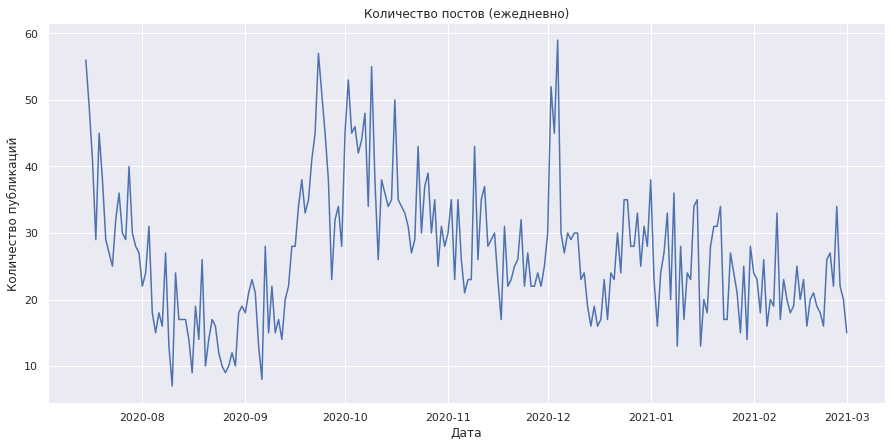

In [45]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=subset_posts, x=subset_posts.index, y=subset_posts.id)
plt.title('Количество постов (ежедневно)')
plt.ylabel('Количество публикаций')
plt.xlabel('Дата')
plt.grid(True)
plt.savefig(PATH + "Full_analysis/posts_by_day_din.png", dpi=300, bbox_inches='tight')

In [46]:
subset_com = df.resample('D').apply({'commentsCount':'sum'})
subset_com = subset_com[subset_com.index > '2020-07-14']

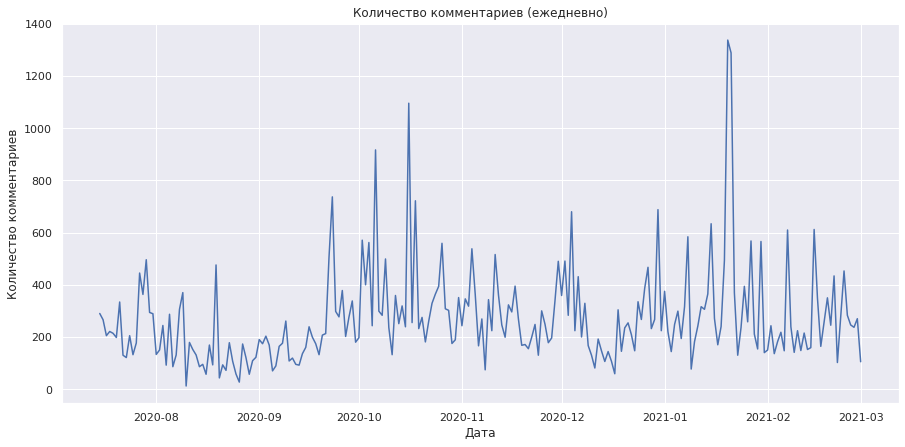

In [47]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=subset_com, x=subset_com.index, y=subset_com.commentsCount)
plt.title('Количество комментариев (ежедневно)')
plt.ylabel('Количество комментариев')
plt.xlabel('Дата')
plt.grid(True)
# plt.savefig(PATH + "Full_analysis/comments_by_day_din.png", dpi=300, bbox_inches='tight')

In [48]:
# tmp = df[df.index > '2021-01-10']

In [49]:
# tmp['commentsCount'].argmax()

In [50]:
# tmp.iloc[270:300, :]

### Немного поиграем с временными рядами

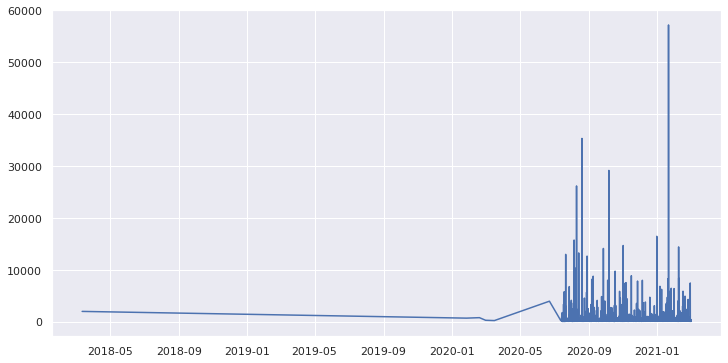

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(df.hitsCount)
plt.grid(True)
plt.show()

In [52]:
df.groupby(['weekday'])['id'].count().values

array([1003,  888,  790,  806,  898,  839,  953])

In [53]:
df.weekday.value_counts().values

array([1003,  953,  898,  888,  839,  806,  790])

In [54]:
df.weekday.value_counts().sort_index()

Friday       1003
Monday        888
Saturday      790
Sunday        806
Thursday      898
Tuesday       839
Wednesday     953
Name: weekday, dtype: int64

In [55]:
df.groupby(['weekday']).count()

,id,url,author,commentsCount,favoritesCount,hitsCount,isRepost,likes,subsite,title,...,author_avatar_url,symbols,words,images,videos,links,audio,hashtags,hour,is_weekend
weekday,,,,,,,,,,,,,,,,,,,,,
Friday,1003,1003,1003,1003,1003,1003,1003,1003,1003,531,...,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003
Monday,888,888,888,888,888,888,888,888,888,469,...,888,888,888,888,888,888,888,888,888,888
Saturday,790,790,790,790,790,790,790,790,790,385,...,790,790,790,790,790,790,790,790,790,790
Sunday,806,806,806,806,806,806,806,806,806,385,...,806,806,806,806,806,806,806,806,806,806
Thursday,898,898,898,898,898,898,898,898,898,455,...,898,898,898,898,898,898,898,898,898,898
Tuesday,839,839,839,839,839,839,839,839,839,447,...,839,839,839,839,839,839,839,839,839,839
Wednesday,953,953,953,953,953,953,953,953,953,469,...,953,953,953,953,953,953,953,953,953,953


In [56]:
# sns.barplot(x=df.weekday.value_counts().index, y=df.groupby(['weekday'])['id'].count().values)

https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib

In [57]:
df.groupby("weekday")["id"].count().mean()

882.4285714285714

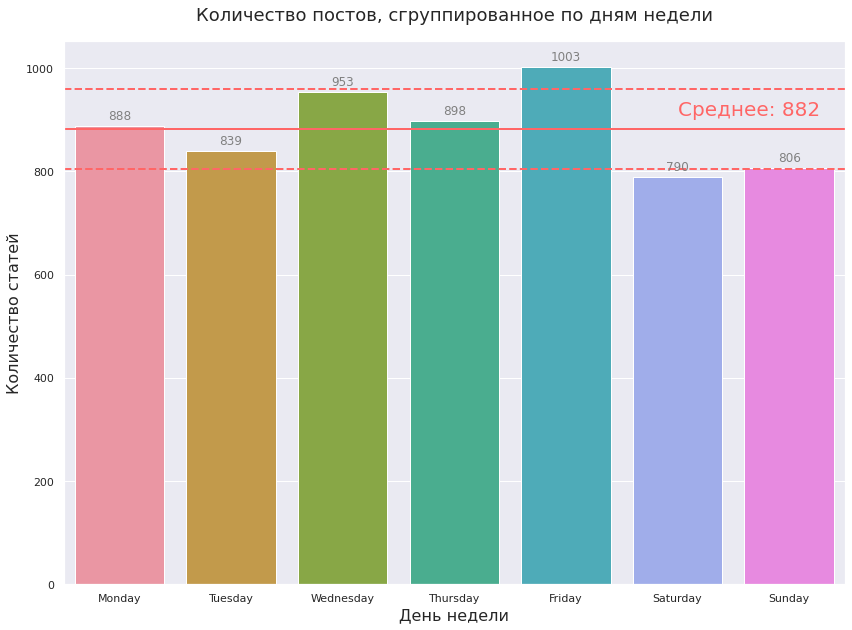

In [58]:
from pandas.api.types import CategoricalDtype

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
df['weekday'] = df['weekday'].astype(cat_type)

sns.set_palette('hls')

ax = sns.barplot(data=df, x=df.groupby("weekday")["id"].count().sort_index().index, 
            y=df.groupby("weekday")["id"].count().sort_index().values)



for p in ax.patches:
    ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')  

plt.axhline(df.groupby("weekday")["id"].count().mean(), color='#ff6666', linestyle='-', linewidth=2)    
plt.text(5.0, df.groupby("weekday")["id"].count().mean()*1.03, 
         'Среднее: {:.0f}'.format(df.groupby("weekday")["id"].count().mean()), color='#ff6666', fontsize=20)
plt.axhline(df.groupby("weekday")["id"].count().mean() + df.groupby("weekday")["id"].count().std(), 
            color='#ff6666', linestyle='--', linewidth=2)
plt.axhline(df.groupby("weekday")["id"].count().mean() - df.groupby("weekday")["id"].count().std(), 
            color='#ff6666', linestyle='--', linewidth=2)
        
ax.set_title('Количество постов, сгруппированное по дням недели', fontsize=18, pad=20)
ax.set_xlabel('День недели', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

# plt.savefig(PATH + "Full_analysis/posts_by_day_sum.png", dpi=300, bbox_inches='tight')

### Возвращаемся к EDA

In [59]:
df.reset_index(inplace=True)
df.head()

,date,id,url,author,commentsCount,favoritesCount,hitsCount,isRepost,likes,subsite,...,symbols,words,images,videos,links,audio,hashtags,hour,weekday,is_weekend
0,2018-03-12 21:59:15,17110,https://dtf.ru/flood/17110-ne-odin-lish-tip-luny,"{'id': 4876, 'url': 'https://dtf.ru/u/4876-geo...",19,32,1947,True,36,Офтоп,...,13588,2012,42,3,0,0,[#long],21,Monday,0
1,2020-01-26 20:38:21,97215,https://dtf.ru/u/92907-aleksey-fedorov/97215-t...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",11,47,649,True,56,Алексей Фёдоров,...,223,29,17,0,0,0,[#anime],20,Sunday,1
2,2020-02-18 19:11:46,104163,https://dtf.ru/u/92907-aleksey-fedorov/104163-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",39,25,740,True,49,Алексей Фёдоров,...,92,12,32,0,0,0,"[#anime, #evangelion]",19,Tuesday,0
3,2020-02-29 18:25:10,108055,https://dtf.ru/u/92907-aleksey-fedorov/108055-...,"{'id': 92907, 'url': 'https://dtf.ru/u/92907-a...",7,18,236,True,41,Алексей Фёдоров,...,150,14,19,0,1,0,[#anime],18,Saturday,1
4,2020-03-16 10:36:03,113363,https://dtf.ru/u/4810-oleg-kubaneishvili/11336...,"{'id': 4810, 'url': 'https://dtf.ru/u/4810-ole...",5,8,180,True,15,Олег Кубанеишвили,...,5057,726,17,0,0,0,[],10,Monday,0


In [60]:
df.groupby(['isRepost']).agg({'id': "count"})

,id
isRepost,
False,5471
True,706


In [61]:
df.groupby(['isRepost']).agg({'id': "count"})['id']

isRepost
False    5471
True      706
Name: id, dtype: int64

In [62]:
tmp = df.groupby(['isRepost', 'author_type'], as_index=False).agg({'id': "count"})
tmp

,isRepost,author_type,id
0,False,1,5379
1,False,2,92
2,True,1,700
3,True,2,6


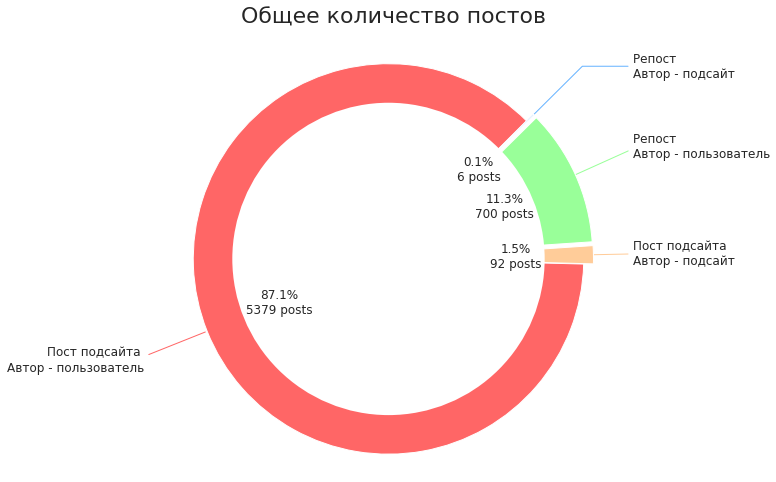

In [71]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['id'],
    shadow=False,
    colors=colors, startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['id']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество постов', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# sns.set_theme()
# sns.set_palette("husl")

# labels = 'Статья подсайта', 'Репост'
# sizes = df.groupby(['isRepost']).agg({'id': "count"})['id'].values
# explode = (0, 0.1)  

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)

# ax1.axis('equal')  
# plt.show()

In [73]:
sns.set_theme()

In [74]:
tmp = df.groupby(['isRepost', 'author_type'], as_index=False).agg({'commentsCount': "sum"})
tmp

,isRepost,author_type,commentsCount
0,False,1,41036
1,False,2,985
2,True,1,19980
3,True,2,343


In [82]:
sns.set_palette("tab10")

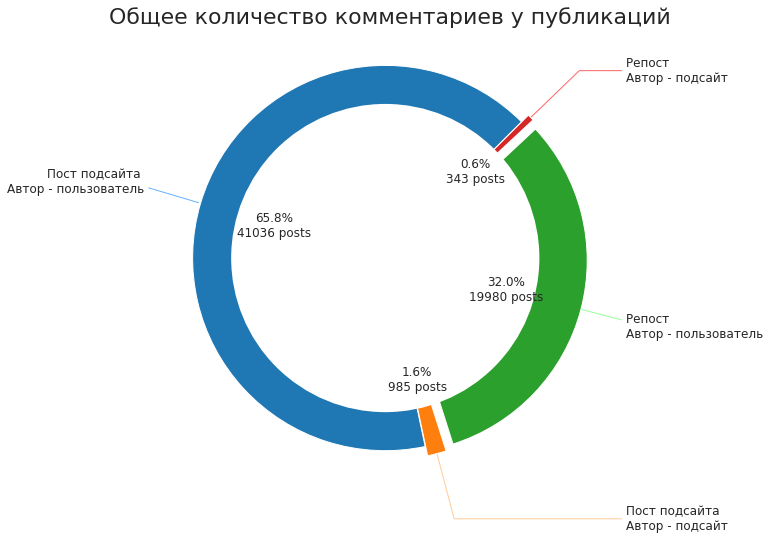

In [89]:
from matplotlib import gridspec

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

fig=plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
# gs2 = gridspec.GridSpec(1,1,
#     left=0.05,right=0.95,
#     bottom=0.9,top=1.0,
# )

pie_ax=fig.add_subplot(gs1[0])
# title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ['#66b3ff', '#ffcc99', '#99ff99', '#ff6666']
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  

# Create a pie chart
wedges = pie_ax.pie(
    tmp['commentsCount'],
    shadow=False,
#     colors=colors, 
    startangle=45, #frame=True, 
    autopct=lambda pct: func(pct, tmp['commentsCount']), 
    explode=(0, 0.05, 0.05, 0.05)
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges[0]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
    pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)


centre_circle = plt.Circle((0,0), 0.8, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Общее количество комментариев у публикаций', fontsize=22, pad=20)

plt.axis('equal')

# plt.savefig(PATH + "Full_analysis/posts.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
sns.set_theme()
sns.color_palette()

sns.scatterplot(x=df.symbols, size=df.likes, hue='isRepost', 
                y=sum([df.images, df.videos, df.links]), data=df)

In [ ]:
sns.lmplot(data=df, x='symbols', y='likes', col='isRepost', hue='isRepost')

In [ ]:
sum((df.isRepost == True) / len(df.isRepost))

In [ ]:
tmp = df.groupby(['author_name'])['author_name'].count().sort_values(ascending=False).head(20)

In [ ]:
tmp

https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn

https://stackoverflow.com/questions/45946970/displaying-of-values-on-barchart

In [ ]:
f = sns.barplot(x=tmp.values, y=tmp.index)
ax = f
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/40066089/apply-images-to-pyplot-python-bar-graphs

# СУПЕР_ВАЖНО!

```python
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

labels = ['CW', 'CV', 'GW', 'SX', 'DO']
colors = ['crimson', 'dodgerblue', 'teal', 'limegreen', 'gold']
values = 30 + np.random.randint(5, 20, len(labels)).cumsum()

height = 0.9
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    # with cbook.get_sample_data('ada.png') as image_file:
    #    img = plt.imread(image_file)
    response = requests.get(f'https://www.countryflags.io/{label}/flat/64.png')
    img = plt.imread(BytesIO(response.content))
    plt.imshow(img, extent=[value - 8, value - 2, i - height / 2, i + height / 2], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()
```

In [ ]:
df.loc[:, 'author']

In [ ]:
# df.loc[:, 'author'][6001] # для timeseries-индекса

In [ ]:
df.loc[6001, 'author']

In [ ]:
df.author_avatar_url

In [ ]:
tmp = df.groupby(['author_avatar_url'])[['id', ]].count().sort_values(by="id", ascending=False).head(20) #\
#.count().sort_values(ascending=False).head(20)
# by="author_name"
tmp

In [ ]:
tmp.index

In [ ]:
# labels
# values

# МЕГА-ВАЖНО!

https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib

https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python

In [ ]:
# Первый, неудачный вариант

# import requests
# from PIL import Image
# from io import BytesIO

# labels = tmp.index[:5]
# colors = ['tan', 'peru', 'grey', 'orchid', 'darkred']
# values = tmp.values.flatten()[:5]

# height = 0.9
# plt.barh(y=tmp.index[:5], width=tmp.values.flatten()[:5], height=height, color=colors, align='center')

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index

In [ ]:
tmp_2 = df.groupby(['author_name','author_avatar_url'], as_index=False).count() \
.sort_values(by="id", ascending=False).head(20).iloc[:, [0,1,3]]
tmp_2

In [ ]:
tmp_2.author_name

In [ ]:
tmp_2.id[:5][::-1]

In [ ]:
import requests
from PIL import Image
from io import BytesIO

labels = tmp_2.author_avatar_url[:5][::-1]
colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
values = tmp_2.id[:5][::-1] #.flatten()[:5]

height = 0.9
plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)

plt.style.use('seaborn')    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()

In [ ]:
ax.patches

In [ ]:
labels = tmp_2.author_avatar_url[:5][::-1]
colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
values = tmp_2.id[:5][::-1] #.flatten()[:5]

height = 0.9
f = sns.barplot(y=tmp_2.author_name[:5][::-1], x=tmp_2.id[:5][::-1])
ax = f

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

# for i, (label, value) in enumerate(zip(labels, values)):
#     im = Image.open(requests.get(label, stream=True).raw)
#     plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
       
    
# plt.xlim(0, max(values) * 1.05)
# plt.ylim(-0.5, len(labels) - 0.5)
# plt.tight_layout()
# plt.show()

In [ ]:
import requests
from PIL import Image
from io import BytesIO

labels = tmp_2.author_avatar_url[:5][::-1]
colors = ['peru', 'tan', 'grey', 'orchid', 'darkred'][::-1]
values = tmp_2.id[:5][::-1] 

height = 0.9
plt.barh(y=tmp_2.author_name[:5][::-1], width=tmp_2.id[:5][::-1], height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 150, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 3, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.tight_layout()
plt.show()

In [ ]:
df.groupby(['author_name']).agg({'id': 'count', 'likes': ['max', 'sum']}).sort_values(by=("id",'count'), ascending=False)

In [ ]:
df.columns

In [ ]:
sns.heatmap(df.loc[:, ['commentsCount', 'favoritesCount', 'hitsCount', 
                       'likes', 'symbols', 'images', 'videos', 'links']].corr(), annot=True)

In [ ]:
df.groupby(['author_name', 'isRepost']).agg({'id': 'count', 'likes': ['max', 'sum']}).sort_values(by=("id",'count'), ascending=False)

In [ ]:
sns.scatterplot(x=df.symbols, y=sum([df.images, df.videos, df.links]), hue='isRepost', data=df)

In [ ]:
sns.histplot(x = df.commentsCount, kde=True)

In [ ]:
sns.histplot(df.hitsCount, kde=True)

In [ ]:
sns.histplot(df.likes, kde=True)

In [ ]:
sns.boxplot(data=df, x="isRepost", y="likes")

In [ ]:
a = df.groupby(['author_name']).agg({'id': 'count'})
a[a['id'] > 1].sort_values(by='id', ascending=False)

In [ ]:
a[a['id'] > 100].index

In [ ]:
tmp = df.groupby(['author_name']).agg({'id': 'count'})

In [ ]:
# sns.boxplot(data=df, y="author_name", x="likes")

In [ ]:
sns.violinplot(y=df.likes)

In [ ]:
from plotnine import *
from plotnine.data import *

https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_violin.html?highlight=violin#violins-boxes-points-and-lines

In [ ]:
(ggplot(df, aes(x=df.isRepost, y=df.likes, fill=df.isRepost)) + geom_violin(show_legend=False) + geom_boxplot(width = .2)
+ scale_fill_manual(values=['dodgerblue', 'darkorange'])
+ theme_classic()
+ theme(figure_size=(8, 6))
)

In [ ]:
df[df.title == 'Статья удалена'].shape[0]

In [ ]:
df[df.title == 'Статья удалена'].author_name.unique()

In [ ]:
df[sum([df.images, df.videos, df.links]) == 0].symbols.unique()

In [ ]:
sum([df.images, df.videos, df.links]).value_counts(normalize=True, sort=True)

In [ ]:
df.shape[0]

In [ ]:
sns.displot(x=df.symbols, y=sum([df.images, df.videos, df.links]), col='isRepost', data=df)

In [ ]:
sns.scatterplot(x=df.symbols, y=sum([df.images, df.videos, df.links]), hue='isRepost', data=df)

In [ ]:
sns.histplot(data=df, x=sum([df.images, df.videos, df.links]), kde=True)

In [ ]:
sns.histplot(data=df, x=df.likes, kde=True)#, bins=70)

https://stackoverflow.com/questions/62884183/trying-to-add-a-colorbar-to-a-seaborn-scatterplot

In [ ]:
plt.rcParams["figure.figsize"] = [20, 16]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x=df.symbols, y=sum([df.images, df.videos, df.links]), hue=df.likes,
                     palette='turbo', data=df)

norm = plt.Normalize(df.likes.min(), df.likes.max())
sm = plt.cm.ScalarMappable(cmap="turbo", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

In [ ]:
X = np.array([df.symbols, sum([df.images, df.videos, df.links])]).T
X

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [ ]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(silhouette_score(X, km.labels_))

print(inertia)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('The Elbow Method showing the optimal k')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=10)
y_pred = kmeans.fit_predict(X)

# Plot the prediction
# plt.scatter(X[:,0], X[:,1], c=y_pred)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred)

In [ ]:
from sklearn.cluster import DBSCAN

X = np.array([df.symbols, sum([df.images, df.videos, df.links])]).T
X

In [ ]:
clustering = DBSCAN(eps=15, min_samples=10)
y_pred = clustering.fit_predict(X)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

### DBScan не работает при различных плотностях кластеров. Собственно это и можно наблюдать.

In [ ]:
np.unique(y_pred)

In [ ]:
from sklearn.cluster import SpectralClustering

X = np.array([df.symbols, sum([df.images, df.videos, df.links])]).T
X

Очень долго работало и не доработало до конца. Нужно попробовать в колабе.

In [ ]:
# clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", affinity='rbf')
# y_pred = clustering.fit_predict(X)

# plt.rcParams["figure.figsize"] = [20, 16]
# print(np.unique(y_pred))

# sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

In [ ]:
from sklearn import cluster
from sklearn.cluster import MeanShift

bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=50)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
y_pred = ms.fit_predict(X)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred, palette='turbo')

# from itertools import cycle
# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

Почему нормально не сошлись алгоритмы кластеризации? 
#### Потому что я сделал чушь. Основные метрики использованных алгоритмов - плотность и расстояние. Учитывая, что я не нормализировал и не стандартизировал входные данные - алгоритмы просто не могли нормально сойтись. 

Слишком высокая дисперсия по абсциссе, по отношению к дисперсию по ординате. 
#### НОРМАЛИЗАЦИЯ НУЖНА ОБЯЗАТЕЛЬНО!

Для DBSCAN важны параметры эпсилон и н_сэмплс - т. е. эпсилон-окрестность точки и количество точек, входящих в эту окрестность, которые необходимы для определения их принадлежности к одному кластеру. 

Следует также попробовать иерархическую кластеризацию на данных. 

In [ ]:
from sklearn import preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled

In [ ]:
clustering = DBSCAN(eps=0.15, min_samples=7)
y_pred = clustering.fit_predict(X_scaled)

plt.rcParams["figure.figsize"] = [20, 16]
print(np.unique(y_pred))

sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=y_pred, palette='turbo')

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
distance_mat = pdist(X_scaled) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма
# plt.figure(figsize=(20, 10))
# dn = hierarchy.dendrogram(Z, leaf_font_size=8., leaf_rotation=90.)

In [ ]:
from scipy.cluster.hierarchy import dendrogram

In [ ]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

## Наконец-то адекватный результат!

In [ ]:
# Зная расстояние
from scipy.cluster.hierarchy import fcluster
# max_d = 25 # Шикарный результат!
max_d = 25
clusters = fcluster(Z, max_d, criterion='distance')
print(np.unique(clusters))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusters, palette='turbo')

- Мем
- заметка
- мини_подборка
- статья
- подборка
- супер_подборка
- лонгрид
- супер_лонгрид

https://scikit-learn.org/stable/modules/mixture.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

https://scikit-learn.org/stable/modules/preprocessing.html



https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://seaborn.pydata.org/tutorial/relational.html

In [ ]:
# Alternative

max_d = 25
clusters = fcluster(Z, max_d, criterion='distance')
print(np.unique(clusters))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusters, style=df.isRepost, palette='turbo', s=50, legend='full')


In [ ]:
df[df["isRepost"] == True].likes

In [ ]:
from scipy.stats import ks_2samp

ks_2samp(df[df["isRepost"] == True].likes, df[df["isRepost"] == False].likes)

https://stackoverflow.com/questions/58665252/python-compare-distribution-scipy-ks-2samp-p-value-always-0-0

https://stats.stackexchange.com/questions/18408/two-samples-of-the-same-distribution

https://stackoverflow.com/questions/36846620/comparing-distributions-with-chi-square-in-python

https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

In [ ]:
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

https://stackoverflow.com/questions/28988627/pandas-correlation-groupby

In [ ]:
df[df.symbols > 40000]

In [ ]:
df[sum([df.images, df.videos, df.links]) > 150]

https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

https://stackoverflow.com/questions/33436221/displaying-rotatable-3d-plots-in-ipython-or-jupyter-notebook

https://matplotlib.org/2.2.5/gallery/mplot3d/rotate_axes3d.html

https://stackoverflow.com/questions/49981313/rotate-interactively-a-3d-plot-in-python-matplotlib-jupyter-notebook

https://stackoverflow.com/questions/14261903/how-can-i-open-the-interactive-matplotlib-window-in-ipython-notebook

https://stackoverflow.com/questions/38326983/how-to-rotate-a-3d-surface-in-matplotlib

https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

https://stackoverflow.com/questions/36296101/donut-chart-python

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b

In [ ]:
# %matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [16, 16]

x,y,z = df.symbols.values, sum([df.images, df.videos, df.links]).values, df.likes.values
x = x.reshape(-1,1)
y = y.reshape(-1,1)
z = z.reshape(-1,1)
x_scaled = StandardScaler().fit_transform(x)
y_scaled = StandardScaler().fit_transform(y)
z_scaled = StandardScaler().fit_transform(z)

fig = plt.figure()
ax = Axes3D(fig)
# # surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.01)
# # fig.colorbar(surf, shrink=0.05, aspect=50)
# # plt.show()

c = np.arange(len(z_scaled)) / len(z_scaled)
# p = ax.scatter3D(x_scaled, y_scaled, z_scaled, c=c)
ax.scatter3D(x, y, z, c=c)

In [ ]:
len(x_scaled)

In [ ]:
x_scaled.reshape(6177)

In [ ]:
# import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata

# x,y,z = df.symbols, sum([df.images, df.videos, df.links]), df.likes
xyz = {'x': x_scaled.reshape(6177), 'y': y_scaled.reshape(6177), 'z': z_scaled.reshape(6177)}

df_plotting = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

# fig = plt.figure(figsize=(12, 8))
# ax = Axes3D(fig, azim=-115, elev=15)
# ax.plot_trisurf(df_plotting.x, df_plotting.y, df_plotting.z, cmap=cm.jet, linewidth=0.2)
# plt.show()

x1 = np.linspace(df_plotting['x'].min(), df_plotting['x'].max(), len(df_plotting['x'].unique()))
y1 = np.linspace(df_plotting['y'].min(), df_plotting['y'].max(), len(df_plotting['y'].unique()))

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((df_plotting['x'], df_plotting['y']), df_plotting['z'], (x2, y2), method='cubic')

# Ready to plot
# z2
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.jet,
                       linewidth=0, antialiased=False, vmin=np.nanmin(z2), vmax=np.nanmax(z2))
# ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Meshgrid Created from 3 1D Arrays')

plt.show()

Эксперимент с построением 3Д-графика можно считать провалившимся. Слишком разная плотность точек, поэтому поверхность получается очень неровной. Хотя, 3Д диаграмма рассеяния, в принципе, неплоха. Только нужно добавить цвета и будет более-менее неплохо. 

https://stackoverflow.com/questions/52444555/seaborn-scatterplot-legend-not-showing

https://stackoverflow.com/questions/44968012/unable-to-show-legend-in-seaborn-distplot



In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

def histogram_plotting(srs: pd.Series, ci_wide=90, desc_stat='mean'):
    """Function for plitting histogram (seaborn) with custom confidence interval
    and descriptive statistics.
    
    Parameters
    ----------
    srs : pd.Series
        Data for which the histogram is plotted. 
        
    ci_wide : int, default=90
        Wide of confidence interval in percents.
        
    desc_stat : str, default="mean"
        Calculated descriptive statistics.

    Returns
    -------
        None. Printing histogram.
    
    """
       
    ci = (100 - ci_wide) / 200
    confidence_interval = list(srs.quantile([ci, 1-ci]))
    
    ax = sns.histplot(srs, kde=True)
    max_bar_height = max([h.get_height() for h in ax.patches])
    
    ax.plot(confidence_interval, [max_bar_height*1.05, max_bar_height*1.05], color='black')
    
    for x in confidence_interval:
        ax.plot([x, x], [0, max_bar_height*1.1], color='black')
        ax.text(x, max_bar_height*1.13, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
    
    ax.text(sum(confidence_interval) / 2, max_bar_height*1.07, str(ci_wide) + '% interval',
                horizontalalignment='center', verticalalignment='center')

    descriptive_statistics = getattr(srs, desc_stat)()

    ax.plot([descriptive_statistics, descriptive_statistics], 
            [0, max_bar_height*1.05], color='black', linestyle='--')
    
    ax.text(descriptive_statistics, max_bar_height*0.15, 
            desc_stat.capitalize() + f': {descriptive_statistics:.0f}',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
            horizontalalignment='center', verticalalignment='center')
    
    ax.set_ylim(0, max_bar_height*1.2)

    plt.tight_layout()
    plt.show()
    
    # END OF FUNC

https://plotly.com/python/pie-charts/

https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

https://plotly.com/python/sunburst-charts/

https://stackoverflow.com/questions/62469436/python-plotly-sunburst-graph-opens-empty-page

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://stackoverflow.com/questions/55806320/how-to-add-box-and-label-to-pie-graph-exactly-as-shown-in-figure-below

https://stackoverflow.com/questions/59153347/matplotlib-pie-donut-chart-annotation-text-size

```python
from matplotlib import gridspec

custpref=pd.DataFrame({'tov_type':['Inpatient','Office Visit','Appointment Schedule','Allergy Sheet'],'count':[7,6,1,1]})

fig=plt.figure(figsize=(6,4))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
gs2 = gridspec.GridSpec(1,1,
    left=0.05,right=0.95,
    bottom=0.9,top=1.0,
)

pie_ax=fig.add_subplot(gs1[0])
title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ["#6287da","#72ac5c","#8653aa","#bb7438","#b94b75"]

# Create a pie chart
wedges, texts = pie_ax.pie(
    # using data total)arrests
    custpref['count'],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with the start angle at 90%
    startangle=90,
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
    pie_ax.annotate(custpref['tov_type'][i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

# View the plot drop above
pie_ax.axis('equal')


title_ax.set_facecolor('k')

title_ax.text(0.5,0.5,"Top 5 Visit Types                  Total = 15 Visits",
    ha="center",va="center",transform=title_ax.transAxes,color="w")

for side in ['top', 'bottom', 'left', 'right']:
    title_ax.spines[side].set_visible(False)
title_ax.axes.get_xaxis().set_visible(False)    
title_ax.axes.get_yaxis().set_visible(False)    

plt.show()
```

In [ ]:
df.head()

In [ ]:
df.groupby(['isRepost', 'author_type']).agg({'id': "count"})

In [ ]:
df.groupby(['isRepost', 'author_type'], as_index=False).agg({'id': "count"})

### Эксперименты с plotly

In [ ]:
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
# Set notebook mode to work in offline
pyo.init_notebook_mode()
# Create traces
fig = px.sunburst(tmp, path=['isRepost', 'author_type'], values='id')
# Plot it and save as basic-line.html
# pyo.iplot(fig, filename = 'sunburst')

In [ ]:
print(tmp.author_type.values)
print(tmp.isRepost.values)
print(tmp.id.values)

In [ ]:
import plotly.graph_objects as go

pprree = ['', '']
pprree.extend(tmp.author_type.values)

pre = ['', '']
pre.extend(tmp.isRepost.values)

fig =go.Figure(go.Sunburst(
    labels=pprree,
    parents=pre,
    values=tmp.id.values
    
))
# fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

На 13.03.2021 Эксперимент не удался. 

In [ ]:
tmp

In [ ]:
# 'Статья подсайта', 'Репост'
# 'Автор - подсайт', 'Автор - пользователь'

In [ ]:
sns.set_theme()

def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)


# Data to plot
labels = ['Пост подсайта \nАвтор - пользователь', 'Пост подсайта \nАвтор - подсайт', 
          'Репост \nАвтор - пользователь', 'Репост \nАвтор - подсайт']# tmp.author_type.values  
sizes = tmp.id.values
# labels_gender = ['Статья подсайта','Статья подсайта', 'Репост', 'Репост'] # tmp.isRepost.values
# sizes_gender = tmp.id.values
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
# colors_gender = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff'] #['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']

 
# Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=45, #frame=True, 
        autopct=lambda pct: func(pct, sizes), explode=(0.03, 0.03, 0.03, 0.03))
# plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, radius=0.75, startangle=90)
centre_circle = plt.Circle((0,0), 0.5, color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
df[(df.words < 50) & (sum([df.images, df.videos, df.links]).eq(1))]

In [ ]:
sum([df.images, df.videos, df.links]).eq(1)

In [ ]:
df['class'] = np.where((df.words < 50) & (sum([df.images, df.videos, df.links]).eq(1)), 0, 1)

In [ ]:
df['class']

In [ ]:
df.head()

In [ ]:
sns.scatterplot(x=df.symbols, y=sum([df.images, df.videos, df.links]), hue='class', data=df)

In [ ]:
df.words.sort_values()

In [ ]:
# [x for x in range(0,20000,50)]

In [ ]:
sns.histplot(df.words.sort_values(), bins=[50,250,500,1000,2000,5000,10000,20000]) #bins=[x for x in range(0,20000,50)]

In [ ]:
df.groupby(['class', 'isRepost']).agg({'likes': ["sum", "median", "mean", "max", "min"]})

In [ ]:
df.likes.sum()

In [ ]:
df[(df['class'] == 0) & (df['likes'] > 500)]

In [ ]:
df[df['likes'] < 0]

In [ ]:
tmp

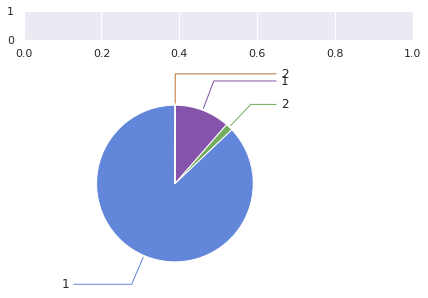

In [65]:
custpref=pd.DataFrame({'tov_type':['Inpatient','Office Visit','Appointment Schedule','Allergy Sheet'],'count':[7,6,1,1]})

fig=plt.figure(figsize=(6,4))
gs1 = gridspec.GridSpec(1,1,
    left=0.1,right=0.7,
    bottom=0.1,top=0.7,
)
gs2 = gridspec.GridSpec(1,1,
    left=0.05,right=0.95,
    bottom=0.9,top=1.0,
)

pie_ax=fig.add_subplot(gs1[0])
title_ax=fig.add_subplot(gs2[0])

# Create a list of colors (from iWantHue)
colors = ["#6287da","#72ac5c","#8653aa","#bb7438","#b94b75"]

# Create a pie chart
wedges, texts = pie_ax.pie(
    # using data total)arrests
    tmp['id'],
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    # with the start angle at 90%
    startangle=90,
)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
    pie_ax.annotate(tmp['author_type'][i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

# View the plot drop above
pie_ax.axis('equal');

# Аналитика за февраль

In [ ]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
fev_subs = df["2021-02"]
fev_subs.reset_index(inplace=True)
fev_subs.head()

In [ ]:
fev_subs.tail()

In [ ]:
fev_subs.shape

In [ ]:
import matplotlib as mpl
sns.set_palette('husl', 10)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} posts".format(pct, absolute)

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(['isRepost']).agg({'id': "count"})['id'].values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Доля репостов от общего количества публикаций за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.commentsCount.sum()

In [ ]:
fev_subs.groupby(["isRepost"]).commentsCount.sum()

In [ ]:
import matplotlib as mpl

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} comments".format(pct, absolute)

sns.set_theme()
sns.set_palette("pastel")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).commentsCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, 
                                    autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)
ax1.axis('equal')
plt.title('Количество комментариев в публикациях за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/comments_parted.png", dpi=300, bbox_inches='tight')
plt.show()

sns.set_theme()

In [ ]:
sns.set_theme()

In [ ]:
from pandas.plotting import table 

In [ ]:
fev_subs.groupby(['isRepost']).agg({'commentsCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, fev_subs.groupby(['isRepost']).agg({'commentsCount': ["sum", "median", "mean", "max", "min"]}))  # where df is your data frame
# plt.tight_layout()
# plt.savefig(PATH + "March_2021/test_table.png", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# sns.histplot(x = fev_subs.commentsCount, data=fev_subs, hue="isRepost", kde=True)
sns.displot(x = fev_subs.commentsCount, data=fev_subs, col="isRepost", kde=True)

Надо попробовать посчитать количество уникальных авторов, которые зарепосчены извне.

In [ ]:
len(fev_subs[fev_subs.isRepost == False].author_name.unique())

In [ ]:
len(fev_subs[fev_subs.isRepost == True].author_name.unique())

In [ ]:
fev_subs[(fev_subs.isRepost == False) & (fev_subs.title != "Статья удалена")].likes.sum()

In [ ]:
fev_subs.groupby(['isRepost']).author_name.unique()

In [ ]:
fev_subs.author_name.unique()

In [ ]:
fev_subs.columns

In [ ]:
fev_subs.hitsCount.sum()

In [ ]:
fev_subs.groupby(['isRepost']).agg({'hitsCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} просмотров".format(pct, absolute)

sns.set_palette("rainbow")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).hitsCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Просмотры публикаций за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_hits.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.favoritesCount.sum()

In [ ]:
fev_subs.groupby(['isRepost']).agg({'favoritesCount': ["sum", "median", "mean", "max", "min"]})

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} добавлений в закладки".format(pct, absolute)

sns.set_palette("summer")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 12.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs.groupby(["isRepost"]).favoritesCount.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Добавления статей в закладки за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_fav.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fev_subs.likes.sum()

In [ ]:
fev_subs[fev_subs.title != 'Статья удалена'].likes.sum()

In [ ]:
fev_subs[fev_subs.title != 'Статья удалена'].groupby(['isRepost']).agg({'likes': ["sum", "median", "mean", "max", "min"]})

In [ ]:
18492 + 4570

In [ ]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d} лайков".format(pct, absolute)

sns.set_palette("Spectral")

plt.rcParams["figure.figsize"] = [14, 10]
mpl.rcParams['font.size'] = 14.0

labels = 'Статья подсайта', 'Репост'
sizes = fev_subs[fev_subs.title != 'Статья удалена'].groupby(["isRepost"]).likes.sum().values
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes), #shadow=True, 
        startangle=90)

texts[0].set_fontsize(14)
texts[1].set_fontsize(14)

ax1.axis('equal')
plt.title('Количество лайков за февраль', fontsize=22, pad=20)

# plt.savefig(PATH + "March_2021/part_of_reposts_likes.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# fev_subs.likes[fev_subs.isRepost == True]
# fev_subs.likes[fev_subs.isRepost == False]

In [ ]:
# fev_subs.groupby(['isRepost']).agg({})

In [ ]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle("Распределение количества лайков у постов")

sns.histplot(x = fev_subs.likes[fev_subs.isRepost == False], 
             data=fev_subs, kde=True, ax=axes[0], bins=20).set_title("Посты подсайта")

sns.histplot(x = fev_subs.likes[fev_subs.isRepost == True], 
             data=fev_subs, kde=True, ax=axes[1], bins=20).set_title("Репосты")


# plt.savefig(PATH + "March_2021/part_of_reposts_dist_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
fev_subs.symbols.sum()

In [ ]:
fev_subs.images.sum() + fev_subs.videos.sum() + fev_subs.links.sum()

In [ ]:
tmp_2 = fev_subs[fev_subs.isRepost == False].groupby(['author_name','author_avatar_url'], as_index=False).agg({"likes": "sum"}) \
.sort_values(by="likes", ascending=False).head(20)
tmp_2.head(10)

In [ ]:
sum(tmp_2.likes[:5])

In [ ]:
sum(tmp_2.likes[:5]) / (fev_subs[(fev_subs.isRepost == False) & (fev_subs.title != "Статья удалена")].likes.sum()) * 100

In [ ]:
plt.rcParams["figure.figsize"] = [14, 20]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

labels = tmp_2.author_avatar_url[::-1]
# colors = ['lightcoral', 'orchid', 'peachpuff', 'coral', 'tan', 'indigo', 'goldenrod', 'pink', 'darkturquoise', 'teal'][::-1]
values = tmp_2.likes[::-1] 

height = 0.9
plt.barh(y=tmp_2.author_name[::-1], width=tmp_2.likes[::-1], height=height, 
         color=my_cmap(rescale(values)), 
         align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 200, value - 20, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Сумма рейтинга за месяц', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-20 авторов по сумме рейтинга за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/authors_top20_sum_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_3 = fev_subs[fev_subs.isRepost == False].groupby(['author_name','author_avatar_url'], as_index=False).count() \
.sort_values(by="id", ascending=False).iloc[:, [0,1,3]].head(10)
tmp_3.head(20)

In [ ]:
sum(tmp_3.id[:3])

In [ ]:
sum(tmp_3.id[:3]) / 518 * 100

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

labels = tmp_3.author_avatar_url[::-1]
colors = ['lightcoral', 'orchid', 'tan', 'peachpuff', 'goldenrod', 'darkred', 'darkturquoise', 'indigo', 'coral', 'pink'][::-1]
values = tmp_3.id[::-1] 

height = 0.9
plt.barh(y=tmp_3.author_name[::-1], width=tmp_3.id[::-1], height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    im = Image.open(requests.get(label, stream=True).raw)
    plt.imshow(im, extent=[value - 8, value - 2, i - height / 2.5, i + height / 2.5], aspect='auto', zorder=2)
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество постов за месяц', fontsize=16)
plt.ylabel('Авторы', fontsize=16)
plt.title('Топ-10 авторов по количеству постов за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/authors_top10_posts.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_4 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='likes', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
tmp_4.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_4.loc[99, 'title'] = "Запись пользователя СынМаэстро"
# tmp_4 = tmp_4[tmp_4.index != 128]
tmp_4

In [ ]:
# tmp_4 = fev_subs.sort_values(by='likes', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# # tmp_4.loc[383, 'title'] = 'Спорт, офис, чулочки и жаркое лето от infin...'
# # tmp_4.loc[581, 'title'] = "Запись пользователя Over9k5000"
# # tmp_4.loc[99, 'title'] = "Запись пользователя СынМаэстро"
# # # tmp_4 = tmp_4[tmp_4.index != 128]
# tmp_4

In [ ]:
from matplotlib import cm

labels = tmp_4.title[::-1]#.astype('str')
values = tmp_4.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_4.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по лайкам за февраль', fontsize=22, pad=20)
plt.tight_layout()

plt.savefig(PATH + "March_2021/top10_posts_likes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_5 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='hitsCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "hitsCount", 'date']]
tmp_5.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
tmp_5.loc[159, 'title'] = '( ͡° ͜ʖ ͡°) Интересный музей в ...' 
tmp_5.loc[353, 'title'] = 'Чулочки, каре и немного игривости от ...' 
tmp_5.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перез...' 
tmp_5.loc[383, 'title'] = 'Спорт, офис, чулочки и жарк...' 
tmp_5.loc[475, 'title'] = "RASP/28 Подборка работ ..."
tmp_5 = tmp_5[tmp_5.index != 128]
tmp_5

In [ ]:
# tmp_5 = fev_subs.sort_values(by='hitsCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "hitsCount", 'date']]
# # tmp_5.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
# # tmp_5.loc[159, 'title'] = '( ͡° ͜ʖ ͡°) Интересный музей в ...' 
# # tmp_5.loc[353, 'title'] = 'Чулочки, каре и немного игривости от ...' 
# # tmp_5.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перез...' 
# # tmp_5.loc[383, 'title'] = 'Спорт, офис, чулочки и жарк...' 
# # tmp_5.loc[475, 'title'] = "RASP/28 Подборка работ ..."
# # tmp_5 = tmp_5[tmp_5.index != 128]
# # tmp_5['title'] = tmp_5['title'].str.slice(0,30) + str("...")
# tmp_5.loc[587, 'title'] = "Удивительный мир видеоигр по мотивам Neon Gene..."
# tmp_5.loc[380, 'title'] = "Neon Genesis Evangelion и эмоции, ..."
# tmp_5.loc[123, 'title'] = 'Отзыв на мангу "О т...'
# # tmp_5.loc[432, 'title'] = 'Гость Блогосф...'
# tmp_5

In [ ]:
from matplotlib import cm

labels = tmp_5.title[::-1]#.astype('str')
values = tmp_5.hitsCount[::-1]

my_cmap = plt.get_cmap("summer")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_5.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(50, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество просмотров', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по просмотрам за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_posts_hits_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_6 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='commentsCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "commentsCount", 'date']]
# tmp_6.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_6['title'] = tmp_6['title'].str.slice(0,50)
tmp_6.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
tmp_6 = tmp_6[tmp_6.index != 128]
tmp_6

In [ ]:
tmp_6 = fev_subs.sort_values(by='commentsCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "commentsCount", 'date']]
tmp_6.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил ...'
# tmp_6['title'] = tmp_6['title'].str.slice(0,50)
# tmp_6.loc[237, 'title'] = 'Арифурэта: Сильнейший ремесленник в мире. Как ...'
# tmp_6 = tmp_6[tmp_6.index != 128]
tmp_6.loc[587, 'title'] = "Удивительный мир ..."
tmp_6.loc[380, 'title'] = "Neon Genesis Evangelion и ..."
tmp_6.loc[197, 'title'] = 'Беспокойные Сердца - ...'
tmp_6.loc[375, 'title'] = 'Re:DTF Жизнь с нуля в...'
tmp_6

In [ ]:
labels = tmp_6.title[::-1]#.astype('str')
values = tmp_6.commentsCount[::-1]

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_6.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество комментариев', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по количеству комментариев за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/alter_top10_posts_comments_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_7 = fev_subs[(fev_subs.isRepost == False)].sort_values(by='favoritesCount', ascending=False).head(11).loc[:, ["id", 'author_name','author_avatar_url', 'title', "favoritesCount", 'date']]
# tmp_7['title'] = tmp_7['title'].str.slice(0,25) + str("...")
tmp_7 = tmp_7[tmp_7.index != 128]
tmp_7.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перезалив, автор Mah...' 
tmp_7

In [ ]:
tmp_7 = fev_subs.sort_values(by='favoritesCount', ascending=False).head(10).loc[:, ["id", 'author_name','author_avatar_url', 'title', "favoritesCount", 'date']]
# tmp_7['title'] = tmp_7['title'].str.slice(0,25) + str("...")
# tmp_7 = tmp_7[tmp_7.index != 128]
# tmp_7.loc[339, 'title'] = 'Он вам не Rintarou Okabe (перезалив, автор Mah...' 
# tmp_7.loc[587, 'title'] = "Удивительный мир ..."
# tmp_7.loc[380, 'title'] = "Neon Genesis Evangelion и ..."
tmp_7.loc[197, 'title'] = 'Беспокойные Сердца - Замечатель...'
tmp_7.loc[353, 'title'] = 'Чулочки, каре и немного игривости ...' 
tmp_7.loc[136, 'title'] = 'Столько интересных аниме п...'
tmp_7.loc[137, 'title'] = 'Японский бренд совм...'
tmp_7.loc[123, 'title'] = 'Отзыв на мангу "О т...'
tmp_7

In [ ]:
plt.rcParams["figure.figsize"] = [16, 10]

labels = tmp_7.title[::-1]#.astype('str')
values = tmp_7.favoritesCount[::-1]

my_cmap = plt.get_cmap("Spectral")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_7.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество добавлений в закладки', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 публикаций по количеству добавлений в закладки за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/alter_top10_posts_favorites_alter.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# fev_subs[(fev_subs["images"] + fev_subs["videos"] + fev_subs["links"]) < 100]

In [ ]:
tmp = fev_subs[#(fev_subs.symbols < 10000) 
               #& ((fev_subs["images"] + fev_subs["videos"] + fev_subs["links"]) < 100) & 
               (fev_subs.isRepost == False)]

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

ax = sns.scatterplot(x=tmp.symbols, hue=tmp.likes, 
                y=sum([tmp.images, tmp.videos, tmp.links]), data=tmp, 
                palette = "rocket_r")
                #cmap="icefire")
ax.set_title('Диаграмма зависимости количества лайков от количества символов и медиаконтента в статье', fontsize=18, pad=20)
ax.get_legend().set_title('Лайки')
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set_xlabel('Количество символов в статье', fontsize='16')
ax.set_ylabel('Количество медиаконтента в статье', fontsize='16');

plt.savefig(PATH + "March_2021/scatterplot.png", dpi=300, bbox_inches='tight')

In [ ]:
tmp_8 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.symbols > 2000)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date', 'symbols']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_8.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_8.loc[237, 'title'] = "Арифурэта: Сильнейший ремесл..."
tmp_8

In [ ]:
labels = tmp_8.title[::-1]#.astype('str')
values = tmp_8.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_8.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(2, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-7 лонгридов (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top7_longreads.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_9 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.images > 5)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
# tmp_8.loc[581, 'title'] = "Запись пользователя Over9k5000"
# tmp_8.loc[99, 'title'] = "Запись пользователя СынМаэстро"
tmp_9

In [ ]:
labels = tmp_9.title[::-1]#.astype('str')
values = tmp_9.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_9.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 подборок (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_sets.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
tmp_10 = fev_subs[(fev_subs.isRepost == False) & (fev_subs.images+fev_subs.videos+fev_subs.links == 1)].sort_values(by='likes', ascending=False).head(10) \
.loc[:, ["id", 'author_name','author_avatar_url', 'title', "likes", 'date']]
# tmp_4.loc[137, 'title'] = 'Японский бренд совместно с CDPR представил линейку одежды и ...'
tmp_10.loc[581, 'title'] = "Запись пользователя Over9k5000"
tmp_10.loc[99, 'title'] = "Запись пользователя СынМаэстро"
tmp_10.loc[429, 'title'] = "Запись пользователя Лолег"
tmp_10.loc[430, 'title'] = "Запись пользователя Лолег"
tmp_10.loc[381, 'title'] = "Запись пользователя Diego Paw"
tmp_10

In [ ]:
labels = tmp_10.title[::-1]#.astype('str')
values = tmp_10.likes[::-1]

my_cmap = plt.get_cmap("Wistia")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
height = 0.9

plt.barh(y=tmp_10.id[::-1].astype("str"), 
         width=values, height=height, 
         align='center', color=my_cmap(rescale(values)))

for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, '{:1.0f}'.format(value), ha = 'left', va = 'center')
    plt.text(5, i, '{}'.format(label), ha = 'left', va = 'center')

    
plt.xlim(0, max(values) * 1.05)
plt.ylim(-0.5, len(labels) - 0.5)
plt.xlabel('Количество лайков', fontsize=16)
plt.ylabel('ID публикации', fontsize=16)
plt.title('Топ-10 мемов (по лайкам) за февраль', fontsize=22, pad=20)
plt.tight_layout()

# plt.savefig(PATH + "March_2021/top10_memes.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [14, 10]

ax = sns.scatterplot(x=df.symbols, hue=df.likes, 
                y=sum([df.images, df.videos, df.links]), data=df[df.isRepost == False], 
                palette = "crest")
                #cmap="icefire")
ax.set_title('Диаграмма зависимости количества лайков от количества символов и медиаконтента в статье', fontsize=18, pad=20)
ax.get_legend().set_title('Лайки')
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set_xlabel('Количество символов в статье', fontsize='16')
ax.set_ylabel('Количество медиаконтента в статье', fontsize='16');


In [ ]:
df[(df.symbols > 20000)]# & (df.isRepost == False)].author_name

In [ ]:
# fev_subs[fev_subs.likes > 150]

In [ ]:
tmp = fev_subs[fev_subs.title == "Статья удалена"]
tmp

In [ ]:
tmp.id.unique()

In [ ]:
sns.scatterplot(x=tmp.likes, #hue=tmp.subsite, 
                y=tmp.hitsCount, data=tmp)

In [ ]:
fev_subs

In [ ]:
fev_subs.set_index('date', inplace=True)
fev_subs.index = pd.to_datetime(fev_subs.index)

In [ ]:
# # #fev_subs.reset_index(inplace=True)
fev_subs.head()

In [ ]:
fev_subs["2021-02-08"]

In [ ]:
feb_ts = fev_subs.resample('D').apply({'id':'count'})
feb_ts["weekday"] = feb_ts.index.weekday
feb_ts

In [ ]:
fe = sns.barplot(data=feb_ts, x=feb_ts.index, y=feb_ts.id)
ax = fe

for item in fe.get_xticklabels():
    item.set_rotation(90)

for p in ax.patches:
             ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')    
        
ax.set_title('Количество постов, публикуемых ежедневно в течение месяца', fontsize=18, pad=20)
ax.set_xlabel('Число месяца', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

plt.savefig(PATH + "March_2021/posts_by_day.png", dpi=300, bbox_inches='tight')

In [ ]:
feb_ts.groupby("weekday").sum()

In [ ]:
days = {'Monday': 'Понедельник', 'Tuesday': 'Вторник', 'Wednesday': 'Среда', 'Thursday': 'Четверг', 
 'Friday': 'Пятница', 'Saturday': 'Суббота',  'Sunday': 'Воскресенье'}  

from pandas.api.types import CategoricalDtype

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
fev_subs['weekday'] = fev_subs['weekday'].astype(cat_type)
# fev_subs['weekday'].replace(to_replace=days, inplace=True)

In [ ]:
sns.set_palette('hls')

ax = sns.barplot(data=fev_subs, x=fev_subs.groupby("weekday")["id"].count().sort_index().index, 
            y=fev_subs.groupby("weekday")["id"].count().sort_index().values)

for p in ax.patches:
             ax.annotate("%.1d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='gray', xytext=(0, 10),
                 textcoords='offset points')  

ax.set_title('Количество постов, сгруппированное по дням недели', fontsize=18, pad=20)
ax.set_xlabel('День недели', fontsize='16')
ax.set_ylabel('Количество статей', fontsize='16');

plt.savefig(PATH + "March_2021/posts_by_day_sum.png", dpi=300, bbox_inches='tight')

In [ ]:
# fev_subs.groupby("weekday")["id"].count().sort_index().values